In [46]:
from tools import make_input, membrane_potential, vonmises
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def linear(N_inputs, A, theta):
    return A-np.linspace(0,A,N_inputs)

In [49]:
print(linear(nb_syn, stimtime, 0))

[250.         166.66666667  83.33333333   0.        ]


In [52]:
nb_syn, noise_density, simtime, stimtime = 4, 1e-4, 2e3, 2.5e2
repetitions = 1
noise, stim, aer = make_input(nb_syn, noise_density, repetitions, simtime, stimtime, function=linear)

min_delay, max_delay = 50, stimtime+100
#delays = np.arange(min_delay,max_delay,(max_delay-min_delay)/nb_syn)
delays = max_delay-linear(nb_syn, stimtime, 0)
delays_2 = max_delay-vonmises(nb_syn, stimtime, 0)
seed_nb = 4
np.random.seed(seed_nb)
synaptic_weights = np.random.rand(nb_syn)*.8+.1
#synaptic_weights *= nb_syn/synaptic_weights.sum()
np.random.seed(seed_nb+1)
synaptic_weights_2 = np.random.rand(nb_syn)*.8+.1
#synaptic_weights_2 *= nb_syn/synaptic_weights_2.sum()

noise, stim_2, aer_2 = make_input(nb_syn, noise_density, repetitions, simtime, stimtime, function=vonmises)

stimtime_shift = stimtime
stim -= int(stimtime_shift)
stim_2 += int(stimtime_shift)
stim_combined = np.hstack([stim, stim_2])

post_spike_n1 = stim_combined + np.vstack([delays, delays]).T
post_spike_n2 = stim_combined + np.vstack([delays_2, delays_2]).T

In [57]:
np.hstack([np.arange(nb_syn-1), np.arange(nb_syn-1)])

array([0, 1, 2, 0, 1, 2])

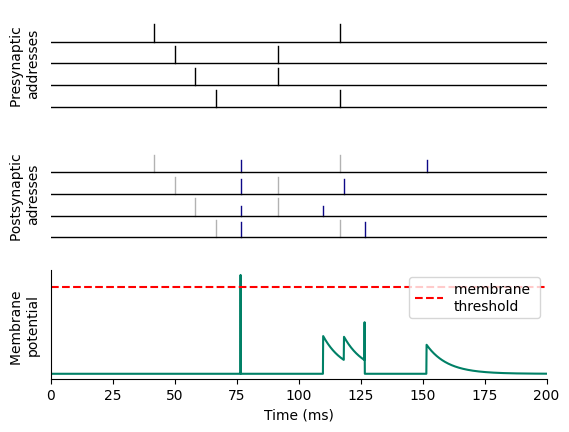

In [58]:
def membrane_potential(aer, simtime, delays, tau, weight):
    addresses, timestamps = aer
    delayed_timestamps = timestamps + np.round(delays[addresses],0)

    sorted_times = np.sort(delayed_timestamps)
    dts = np.diff(np.hstack((0, sorted_times)))
    dts = np.diff(np.arange(simtime))
    V = np.zeros_like(dts)
    for i, dt in enumerate(dts):
        spike_indice = np.where(sorted_times==i)[0]
        if i==0: 
            V[i] = 0
        else:
            if V[i-1]>1: 
                V[i] = 0.
            elif spike_indice.size>0:
                V[i] = np.exp( - dt / tau) * V[i-1] + weight[addresses[spike_indice[0]]]
                if spike_indice.size>1:
                    for nb_spike in range(1,len(spike_indice)):
                        V[i] += weight[addresses[spike_indice[nb_spike]]]
            else:
                V[i] = np.exp( - dt / tau) * V[i-1]
    return sorted_times, V


bottom = .1
top = .9
h_spacing = (top-bottom)/nb_syn
linewidth = 1
spik_height = .8*h_spacing
color_noise = 'black'
color_stim = 'black'
color_n1 = 'green'
color_n2 = 'orange'

colormap = plt.cm.get_cmap('plasma', 1000);
colormap2 = plt.cm.get_cmap('summer_r', 1000);

colors = ["#1f77b4","#ff7f0e","#2ca02c","#f61600","#7834a9",
"#17becf","#684427","#fa5deb","#17becf","#17becf"]

sorted_times, V = membrane_potential((np.hstack([np.arange(nb_syn), np.arange(nb_syn)]), np.hstack([stim[:,0], stim_2[:,0]])), simtime, delays, stimtime/3, synaptic_weights)

fig, ax = plt.subplots(3,1)#, figsize=(fig_width, fig_height))
ax[0].spines[['bottom', 'top', 'right', 'left']].set_visible(False)
ax[0].set_xticks(());
ax[0].set_yticks(());
for syn in range(nb_syn):
    presyn_lines = plt.Line2D([0, simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing], linewidth=linewidth, c='black')
    ax[0].add_artist(presyn_lines)
    for ev in range(stim_combined.shape[1]):
        presyn_spikes_stim = plt.Line2D([stim_combined[syn][ev]/simtime,stim_combined[syn][ev]/simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing+spik_height], linewidth=linewidth, c=color_stim)
        ax[0].add_artist(presyn_spikes_stim)
    
ax[1].spines[['bottom', 'top', 'right', 'left']].set_visible(False)
ax[1].set_xticks(());
ax[1].set_yticks(());
for syn in range(nb_syn):
    for ev in range(post_spike_n1.shape[1]):
        post_spikes_n1 = plt.Line2D([post_spike_n1[syn][ev]/simtime,post_spike_n1[syn][ev]/simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing+spik_height*synaptic_weights[syn]], linewidth=linewidth, c=colormap(0))
        #post_spikes_n2 = plt.Line2D([post_spike_n2[syn][ev]/simtime,post_spike_n2[syn][ev]/simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing+spik_height*synaptic_weights_2[syn]], linewidth=linewidth, c=color_n2)
        ax[1].add_artist(post_spikes_n1)
        #ax[1].add_artist(post_spikes_n2)
        presyn_spikes_stim = plt.Line2D([stim_combined[syn][ev]/simtime,stim_combined[syn][ev]/simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing+spik_height], linewidth=linewidth, c=color_stim, alpha=.3)
        ax[1].add_artist(presyn_spikes_stim)
        #ax[1].quiver([stim_combined[syn][ev]/simtime], [bottom+syn*h_spacing], [(post_spike_n1[syn][ev]-stim_combined[syn][ev])/simtime], [0], scale = 10, color='orange', alpha=.3, headwidth = 3, headlength = 4, headaxislength = 3)
    presyn_lines = plt.Line2D([0, simtime],[bottom+syn*h_spacing, bottom+syn*h_spacing], linewidth=linewidth, c='black')
    ax[1].add_artist(presyn_lines)
    
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].plot(np.arange(0,simtime-1, 1)/10, V, color=colormap2(1000))
ax[2].set_xlim([0,simtime/10])
ax[2].hlines(2, 0, simtime/10, linestyle='dashed', color='red', label='membrane \nthreshold')
ax[2].set_yticks(());

ax[0].set_ylabel('Presynaptic \naddresses');
ax[1].set_ylabel('Postsynaptic \nadresses');
ax[2].set_ylabel('Membrane \npotential');
ax[2].set_xlabel('Time (ms)');
ax[2].legend()
    
plt.show()

In [59]:
fig.savefig('activity_HDSNN.pdf')

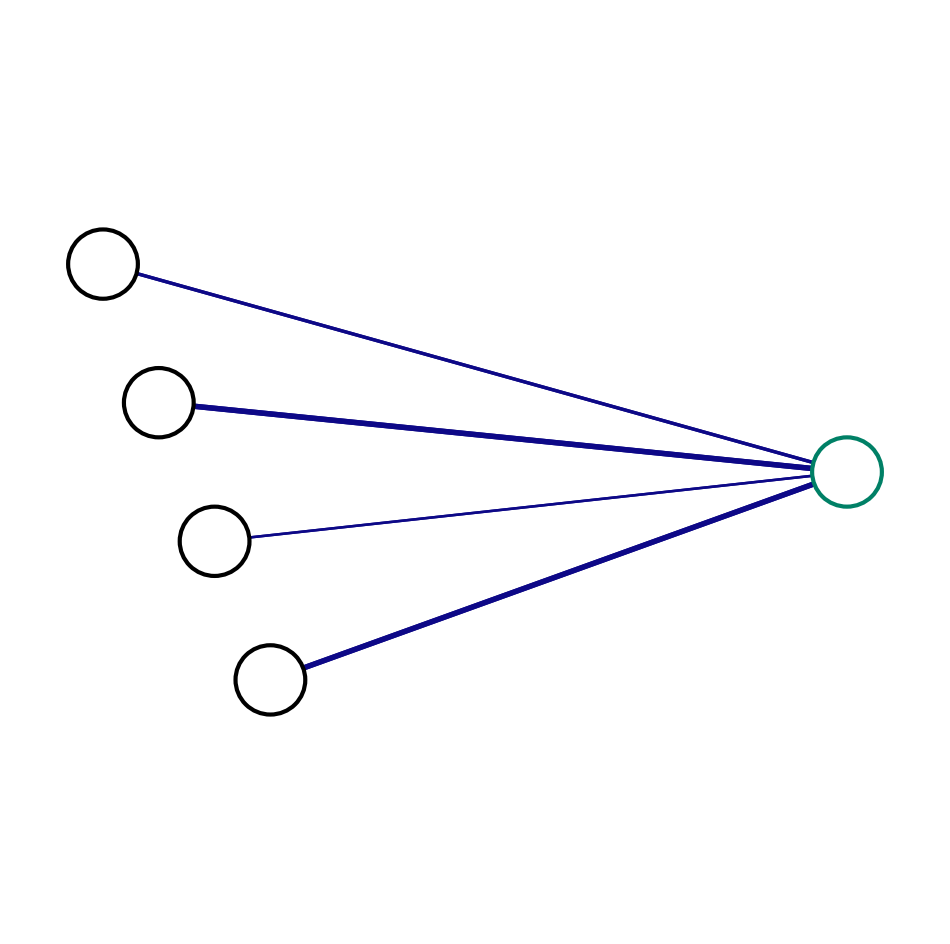

In [60]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, weight):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    linewidth=3
    delay_shift = .6
    
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left*(m*delay_shift+1), layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4, linewidth=linewidth)
            if layer_size==layer_sizes[-1]:
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec=colormap2(1000), zorder=4, linewidth=linewidth)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left*(m*delay_shift+1), (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c=colormap(0), linewidth=(1+linewidth)*(.3+weight[m]**3))
                ax.add_artist(line)
        #for o in range(layer_size_b):
        #    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
        #                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], color='red')
            ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .2, .8, [nb_syn,1], np.flip(synaptic_weights))

In [61]:
fig.savefig('graph_HDSNN.pdf')